# Imports

In [1]:
from pathlib import Path
from itertools import product

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib
import matplotlib.gridspec as gridspec

from tqdm.notebook import tqdm
from scipy.stats import kendalltau
from scipy import interpolate

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env.vec_normalize import VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import PPO

from rl import get_template_ecg, SigmaECGEnv, lognpdf

# Load the Model

In [2]:
model = PPO.load("PPO_vanilla_normalized_final")

# Prepare the environement

In [3]:
ecg_beat_template, lower_bound, upper_bound = get_template_ecg()

log_path = Path('Training', 'Logs')
log_path.mkdir(exist_ok=True, parents=True)

segment_df = pd.read_pickle("/Users/christian/Library/CloudStorage/OneDrive-UniversityofSouthCarolina/Data/clean_ecg_for_RL.pck")
env = SigmaECGEnv(segment_df, lower_bound, upper_bound, ecg_beat_template)
env = VecNormalize(DummyVecEnv([lambda: Monitor(env)]))

# Extract parameters for all beats

In [ ]:
def params_array_to_dict_flat(params):
    return {f"{comp}_{par}": value for (comp, par), value 
            in zip(list(product("PQRSTU", ["mu", "sigma", "t0", "D"])), params)}

recompute = False

env.max_iter = 2000
env.max_no_progress = 200


for no, row in tqdm(list(segment_df.iterrows())):
    path = Path(f"ind_params_{row['subject']}_{row['age']}_{row['condition']}.csv")
    if not recompute and path.exists():
        print(f"Skipping {no} {path}. Already exists.")
        continue


    res = []
    print(*row[['subject', 'age', 'condition']])
    for i in tqdm(np.arange(row.clean_beats.shape[0]), leave=False):
        res_dict = row[['subject', 'age', 'condition']].to_dict()
        state = env.reset()
        state = env.env_method("reset_set", row=row, mean=False, selected_beat_ind=i)[0]
        beat_no = env.get_attr("selected_beat_ind")[0]
        done = False

        while True:
            action = model.predict(state)[0]
            state, reward, done, info = env.step(action)
            if done:
                break

            best_snr =  np.array(env.get_attr("best_snr")).squeeze()
            best_solution =  np.array(env.get_attr("best_solution")).squeeze()

        print(np.round(best_snr, 2), end=" ")

        assert(np.all(np.diff(np.arange(5)) > 0))

        res_dict['no_beat'] = i
        res_dict['snr'] = best_snr
        res_dict.update(params_array_to_dict_flat(best_solution))
        res.append(res_dict)


    pd.DataFrame(res).to_csv(path)            
env.close()    

# Create figure for fitting SNR

In [4]:
fig = plt.figure(figsize=(6.5, 8), facecolor='white') #constrained_layout=False, 

gs1 = gridspec.GridSpec(1, 1, wspace=0)        
ax_dist = fig.add_subplot(gs1[0, 0])
gs1.tight_layout(fig, rect=[0.02, 0.79, 1.0, 0.97], w_pad=0.0, h_pad=0.0)

gs2 = gridspec.GridSpec(6, 2)        
axes = [[fig.add_subplot(gs2[0, 0])]]
axes[0] += [fig.add_subplot(gs2[0, 1], sharex=axes[0][0])]
axes += [[fig.add_subplot(gs2[row, col], sharex=axes[0][0]) for col in range(2)] for row in range(1, 6)]
axes = np.array(axes)

for ax in axes.ravel():
#    #ax.set(frame_on=False)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
axes[-1, 0].axes.xaxis.set_visible(True)
axes[-1, 1].axes.xaxis.set_visible(True)

gs2.tight_layout(fig, rect=[-0.03, 0.02, 1.0, 0.76], w_pad=0.01)#, h_pad=-0.5)

fig.text(0.0, 0.98, "a)")
fig.text(0.0, 0.77, "b)")

plt.close()

/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_35638/3634038538.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs2.tight_layout(fig, rect=[-0.03, 0.02, 1.0, 0.76], w_pad=0.01)#, h_pad=-0.5)


In [5]:
env.max_iter = 100000
env.max_no_progress = 10000


signals = []
snrs = []

np.random.seed(2344234)


for (no, row), ax in tqdm(list(zip(segment_df.sample(frac=1).iterrows(), axes.ravel()))):
    path = Path(f"data/ind_params_{row['subject']}_{row['age']}_{row['condition']}.csv")
    print(*row[['subject', 'age', 'condition']])
    i = np.random.choice(np.arange(row.clean_beats.shape[0]), 1)[0]
    res_dict = row[['subject', 'age', 'condition']].to_dict()
    state = env.reset()
    state = env.env_method("reset_set", row=row, mean=False, selected_beat_ind=i)[0]
    beat_no = env.get_attr("selected_beat_ind")[0]
    done = False


    best_snr = -10
    best_solution = None
    while True:
        action = model.predict(state)[0]
        state, reward, done, info = env.step(action)
        if done:
            break

        best_snr =  np.array(env.get_attr("best_snr")).squeeze()
        best_solution =  np.array(env.get_attr("best_solution")).squeeze()
        signal = np.array(env.get_attr("target_beat")).squeeze()
        t = np.array(env.get_attr("t")).squeeze()



    ax.plot(t, signal)

    params = best_solution.reshape(len(best_solution) // 4, 4)
    sim_sig = np.sum(lognpdf(t, mu=params.T[0, :, None],
                        sigma=params.T[1, :, None],
                        t0=params.T[2, :, None],
                        D=params.T[3, :, None]), axis=0)
    ax.plot(t, sim_sig, linestyle="dashed")
    ax.set_xlim(t[0], t[-1])

    ax.text(0.5, 0.8, f"{np.round(best_snr, 2)} dB",
            transform=ax.transAxes)

axes[-1, 0].set_xlabel("normalized time")
axes[-1, 1].set_xlabel("normalized time")

  0%|          | 0/12 [00:00<?, ?it/s]

1038 1m PIX_ET
1038 3m ET
1008 4m OIX
1016 6m ET
1002 6m OIX
1012 4m ET
1005 12m DEV2
1007 12m ET
1026 2m DEV1
1027 4m DEV3
1019 6m PIX
1002 9m DEV1


Text(0.5, 50.99999999999994, 'normalized time')

In [ ]:
df_ind_peaks =  pd.concat([pd.read_csv(Path(f"data/ind_params_{row['subject']}_{row['age']}_{row['condition']}.csv")).loc[:, "subject":] 
                       for _, row in tqdm(list(segment_df.iterrows()))]).reset_index()

sns.histplot(df_ind_peaks.snr, stat="density", ax=ax_dist)
ax_dist.axvline(x=5, color="r", linestyle="dashed")

ax_dist.set_title(f"Discaded breats (SNR < 5 dB): {np.round(np.sum(df_ind_peaks.snr < 5)/len(df_ind_peaks.snr)*100, 1)}%\n"
      f" ({np.sum(df_ind_peaks.snr < 5):,}/{len(df_ind_peaks.snr):,})")

df_ind_peaks = df_ind_peaks[df_ind_peaks.snr >= 5]

df_means = df_ind_peaks.groupby(["age", "subject", "condition"]).mean().reset_index()
df_means = df_means.groupby(["age", "subject"]).mean().reset_index()

ages = np.array([age.split("m")[0] for age in df_means.age]).astype(object)
ages[ages == "1w"] = 0.25
df_means["age_num"] = ages.astype(float)

df_means = df_means.groupby(["age", "subject", "age_num"]).mean().reset_index()

# Keeping only the time points with at least 10 subjects
tmp = df_means.groupby(["age_num"]).count()
print(dict(tmp["age"]))

df_means = df_means[np.in1d(df_means.age_num,tmp.index[tmp["subject"] >= 8])]

ax_dist.set_xlabel("Individual peak SNR (dB)")


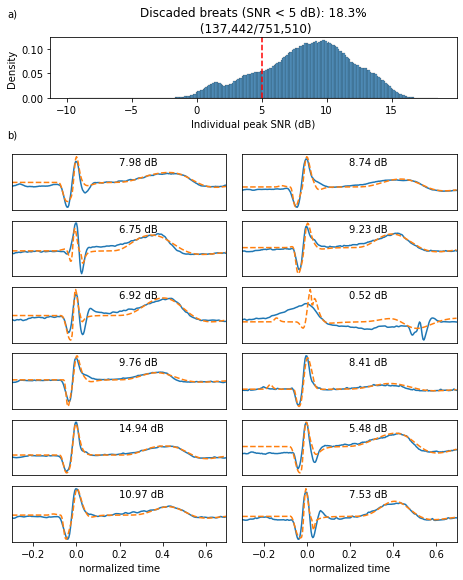

In [99]:
fig.savefig("snr_dist.png", dpi=300)
fig

# Investigating the effect of age on lognormal parameters 

### Function definitions

In [ ]:
def plot_dists(df):
    mean_melted = df.melt(id_vars=df.columns[:7], value_vars=df.columns[7:], var_name="parameter")
    mean_melted["comp"], mean_melted["param"] = np.stack(mean_melted.parameter.str.split("_").values).T
    mean_melted.loc[mean_melted.comp == "T", "comp"] = "T+"
    mean_melted.loc[mean_melted.comp == "U", "comp"] = "T-"

    sns.displot(data=mean_melted, x="value", col="param", row="comp", kind="kde", 
                facet_kws=dict(sharex=False, sharey=False), rug=True)


    fig, axes = plt.subplots(6, 4, figsize=(15, 15))
    for col, ax in zip(df_means.loc[:, 'P_mu':"U_D"].columns, axes.ravel()):
        ax.plot(df_means.sort_values("age_num")[col], ".")
        ax.set_title(col)
        
    fig.tight_layout()

def get_pred_df(df):
    pred_df = {"age_num": sorted(df.age_num.unique())}
    for param in df.loc[:, 'P_mu':"U_D"].columns:
        md = smf.mixedlm(f"{param} ~ age_num", data=df, groups=df["subject"]).fit()
        pred_df[param] = md.predict(pred_df)
        
    return pd.DataFrame(pred_df).set_index("age_num")

def plot_mean_per_age(pred_df, xlims=(-0.20, 0.1), restore_scale=False, 
                      img_file_name="predicted_pqrst.png", fig_axes=None,
                      show_legend=True):

    t_min = max([t[0] for t in segment_df.raw_t])
    t_max = min([t[-1] for t in segment_df.raw_t])
    new_t = np.linspace(t_min, t_max, 1000)

    cmap = matplotlib.cm.get_cmap('Reds')
    rgba = cmap(np.linspace(0, 1, pred_df.shape[0]))

    ages = np.array([age.split("m")[0] for age in segment_df.age]).astype(object)
    ages[ages == "1w"] = 0.25
    segment_df["age_num"] = ages.astype(float)

    t2 = np.arange(-1, 1, 1/250)


    if fig_axes is None:
        fig, axes = plt.subplots(3, 1, figsize=(6, 9), sharex=True, sharey=True)
    else:
        fig, axes = fig_axes
    t = np.arange(-0.4, 0.6, 1/1000)
    for color, (age_num, row) in zip(rgba, pred_df.iterrows()):
        param_dict = {ln: {} for ln in "PQRSTU"}
        for param_name in row.to_dict():
            ln, par = param_name.split("_")
            param_dict[ln][par] = row[param_name]
            
        template = np.sum(np.array([lognpdf(t, **ln) for ln in param_dict.values()]), axis=0)
        axes[0].plot(t, template*1e6, color=color, label=age_num)

        if restore_scale:
            raws = []
            for raw, t in zip(segment_df.raw_beats[segment_df.age_num == age_num], 
                              segment_df.raw_t[segment_df.age_num == age_num]):
                x = np.arange(0, 10)
                y = np.exp(-x/3.0)
                f = interpolate.interp1d(t, raw)
                raws.append(f(new_t).mean(0))

            axes[1].plot(new_t, np.mean(np.stack(raws), 0)*1e6, color=color)       
            axes[2].plot(new_t, np.median(np.stack(raws), 0)*1e6, color=color)        
        else:
            mean_beats = segment_df[segment_df.age_num == age_num]["mean_beat"].values
            axes[1].plot(t2, np.mean(np.stack(mean_beats), 0)*1e6, color=color)
            axes[2].plot(t2, np.median(np.stack(mean_beats), 0)*1e6, color=color)

    for ax in axes:
        ax.set_xlim(*xlims)
        ax.set_ylabel("ECG (uV)")    


    axes[0].set_title("Sigma-Lognormal prediction")
    axes[1].set_title("Mean PQRST across subjects")
    axes[2].set_title("Median PQRST across subjects")

    if show_legend:
        axes[0].legend(title="age (months)", ncol=3)    

    axes[-1].set_xlabel("Normalized time")       

def kendall_pval(x, y): return kendalltau(x, y)[1]

def kendall_cor(x, y): return kendalltau(x, y)[0]

def compute_mixedlm_pvals(df):
    p = df.corr(method=kendall_pval)["age_num"]["P_mu":"U_D"]
    cor = df.corr(method=kendall_cor)["age_num"]["P_mu":"U_D"]
    corrected_p = p*len(p)

    return corrected_p, cor

def plot_param_age_trends(df, fig_file_name="parameter_trends.png"):
    corrected_p, cor = compute_mixedlm_pvals(df)

    df = df.copy().rename(columns={"age_num": "age (months)"})
    for comp in "PQRSTU":
        df[comp + "_D"] /= 1e-6

    tmp = df.melt(id_vars=df.columns[:6], 
                        value_vars=df.columns[6:],
                        var_name="parameter")
    tmp["comp"], tmp["param"] = np.stack(tmp.parameter.str.split("_").values).T
    tmp.loc[tmp.comp == "T", "comp"] = "T+"
    tmp.loc[tmp.comp == "U", "comp"] = "T-"

    g = sns.relplot(data=tmp, x="age (months)", y='value', col="param", row="comp", 
                    kind="line", facet_kws=dict(sharey=False), height=2.5, aspect=1.2)                

    for ax in g.axes.ravel():
        title = ax.get_title()
        comp, param = title.split("|")
        comp = comp.split("=")[1].strip()
        param = param.split("=")[1].strip()
        p = corrected_p[comp.replace("T+", "T").replace("T-", "U") + "_" + param]
        tau = cor[comp.replace("T+", "T").replace("T-", "U") + "_" + param]

        disp_param = title.replace("t0", "$t_0$").replace("mu", "$\mu$").replace("sigma", "$\sigma$")

        ax.set_title(rf"{disp_param}", fontdict={"size":10})
        ax.text(0.5, 0.05, rf"p={p:.1e}; $\tau$={tau:.2}", 
                fontdict={"size":10}, transform=ax.transAxes, 
                ha="center", color="red" if p < 0.01 else "black")


    for ax in g.axes.T[0]:
        ax.set_ylabel("")

    g.figure.tight_layout()
    g.figure.savefig(fig_file_name, dpi=300)

# Without adjusting for the effect of age on heart rhythm

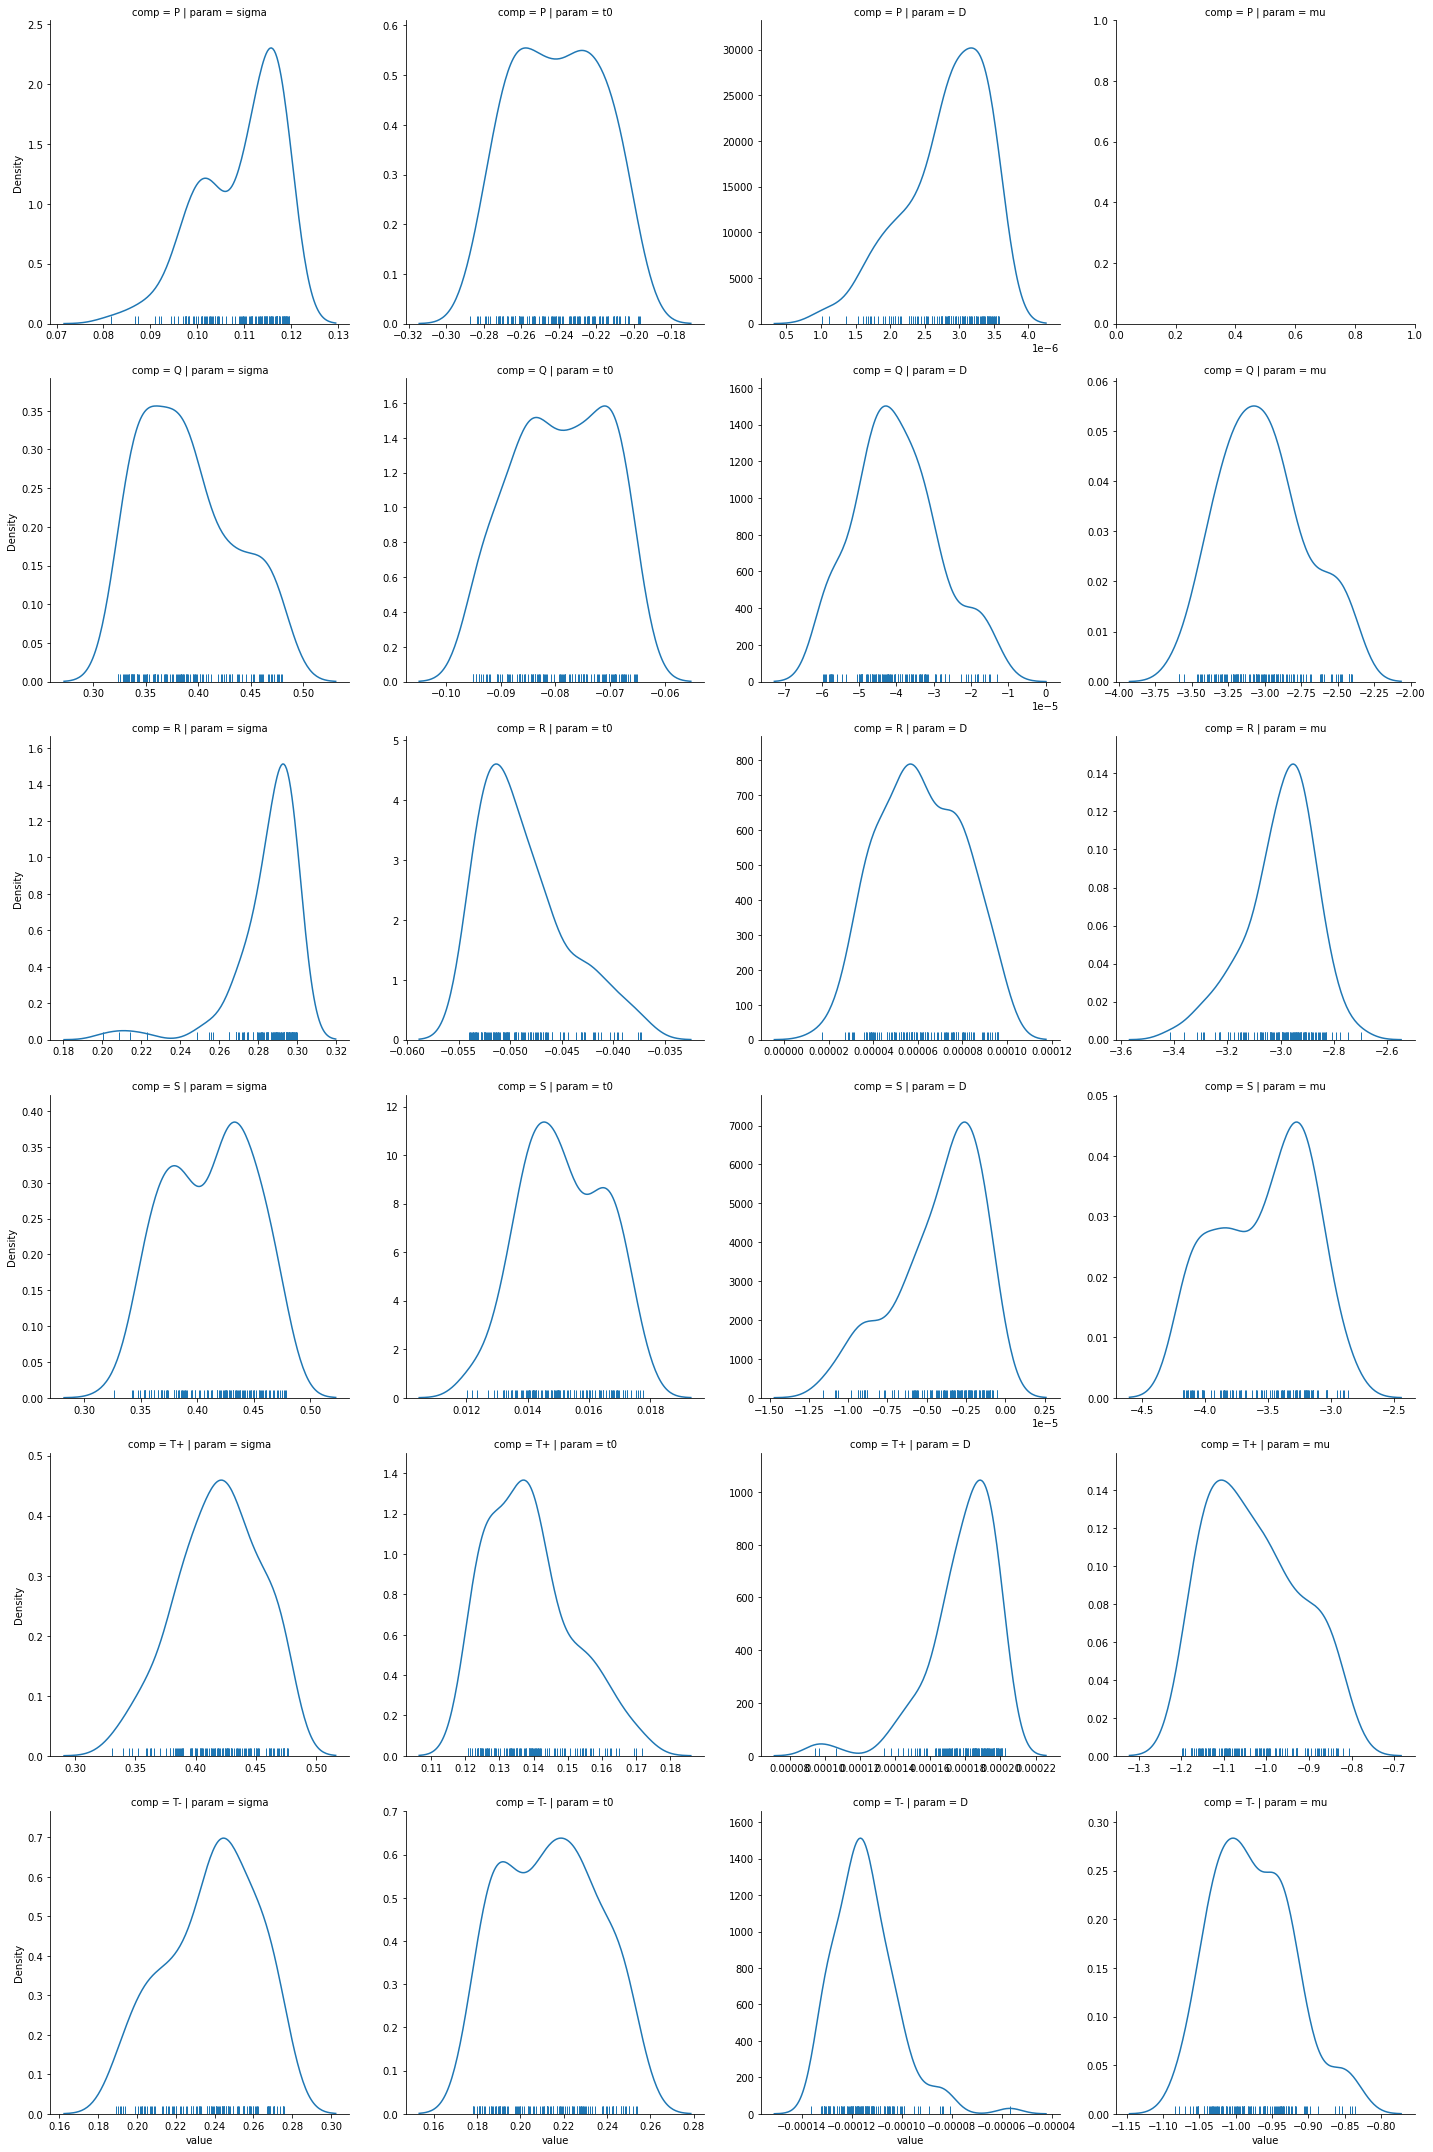

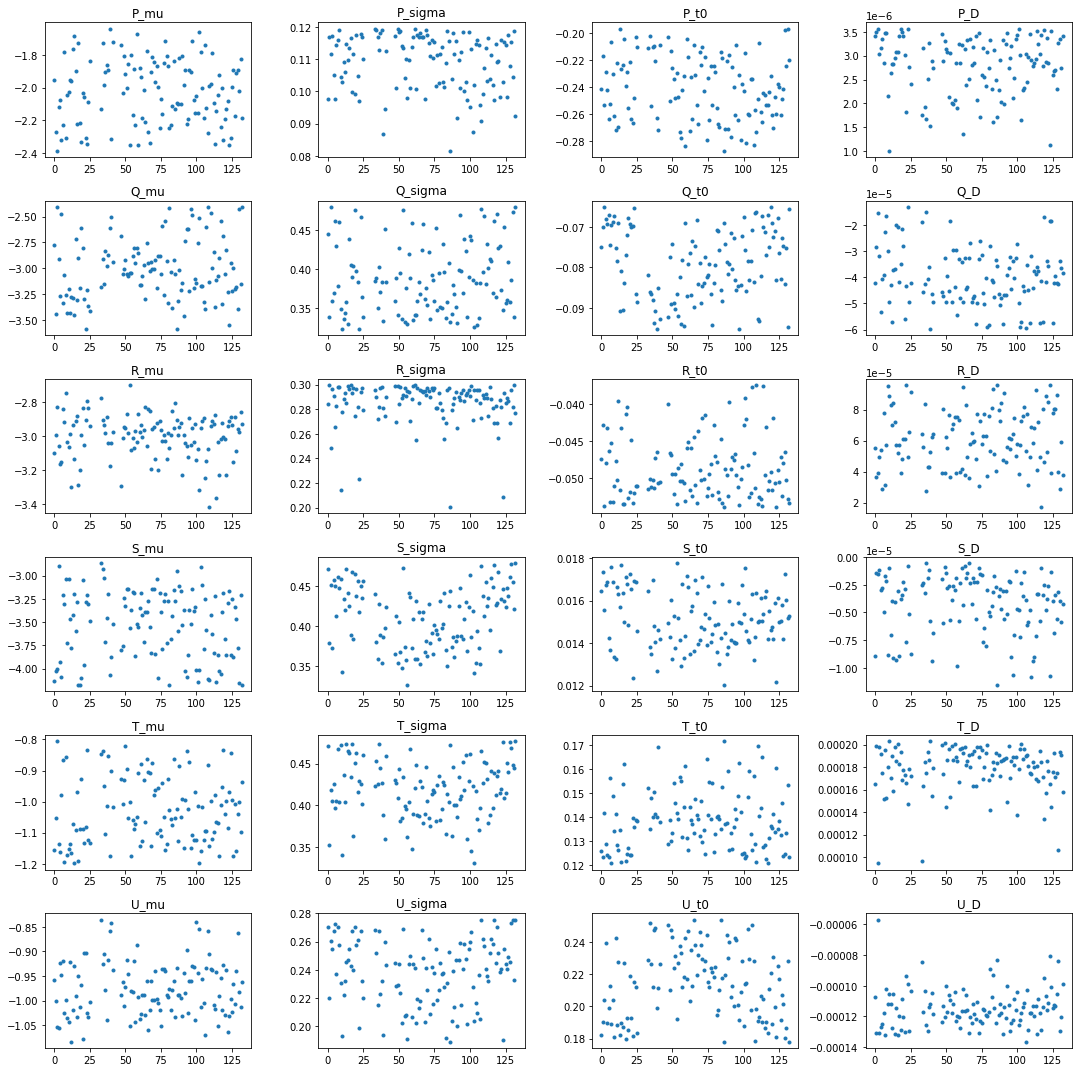

In [15]:
plot_dists(df_means)

In [ ]:
pred_df = get_pred_df(df_means)

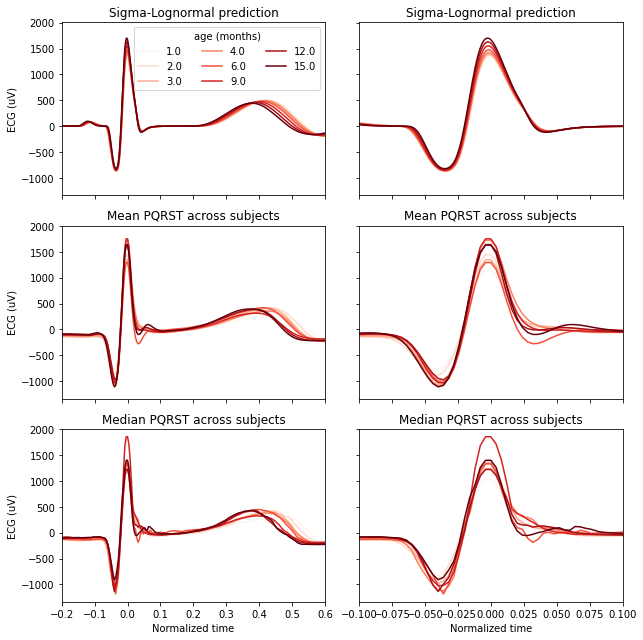

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(9, 9), sharex="col", sharey=True)

plot_mean_per_age(pred_df, xlims=(-0.20, 0.6), restore_scale=False, fig_axes=(fig, axes.T[0]))
plot_mean_per_age(pred_df, xlims=(-0.10, 0.1), restore_scale=False, fig_axes=(fig, axes.T[1]), show_legend=False)

for ax in axes.T[1]:
    ax.set_ylabel("")

fig.tight_layout()

fig.savefig("predicted_pqrst.png", dpi=300)

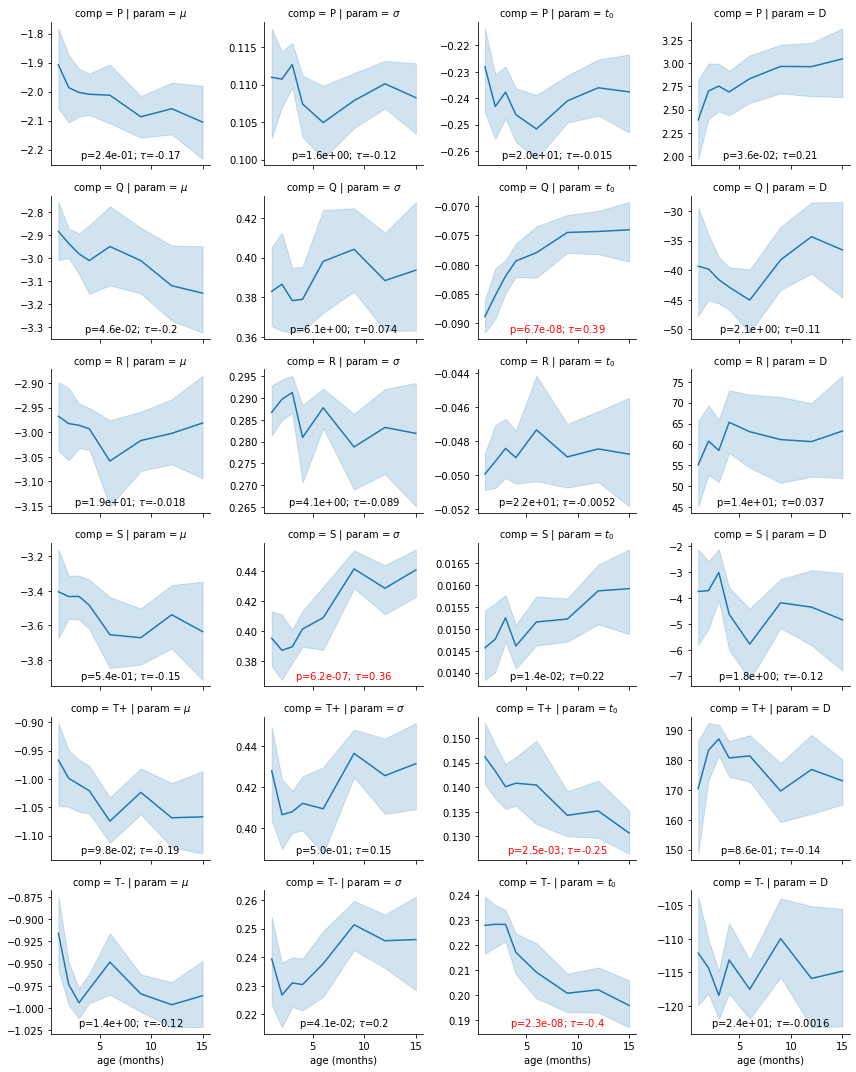

In [22]:
plot_param_age_trends(df_means, "parameter_trends.png")

# Effect of age on heart rhythm

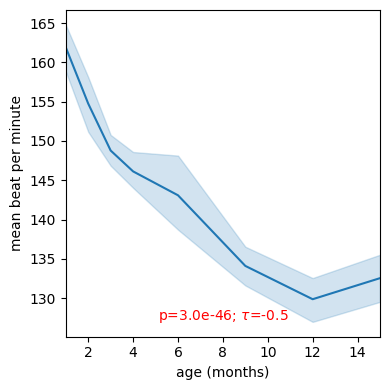

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

instant_bpms = 1/((segment_df.rel_p1 + segment_df.rel_p3)/2/segment_df.sfreq)*60
segment_df["mean_bpm"] = [np.median(series) for series in instant_bpms.values]
tmp = segment_df[["age_num", "mean_bpm"]].copy()
tmp = tmp[np.in1d(tmp.age_num, df_means.age_num.unique())]

p = tmp.corr(method=kendall_pval)["age_num"]["mean_bpm"]
cor = tmp.corr(method=kendall_cor)["age_num"]["mean_bpm"]

g = sns.lineplot(data=tmp, x="age_num", y="mean_bpm", ax=ax)

g.axes.set_ylabel("mean beat per minute")
g.axes.set_xlabel("age (months)")
g.axes.set_xlim(tmp.age_num.min(), tmp.age_num.max())

g.axes.text(0.5, 0.05, rf"p={p:.1e}; $\tau$={cor:.2}", 
        fontdict={"size":10}, transform=g.axes.transAxes, 
        ha="center", color="red" if p < 0.01 else "black")

fig.tight_layout()
fig.savefig("age_bpm_correl.png", dpi=300)

# Adjusting the parameters for the heart rhythm

It can be shown that for lognormals profile to remain identical numerically, a compression of the time variable t by a factor $\alpha$ such that the new time variables $t^*=\alpha t$ must be compensated by using new parameters $P^*$ from the original parameters $P$ such that $\{\mu^*, \sigma^*, t_0^*, D^*\} = \{\mu + log(\alpha), \sigma, \alpha t_0, \alpha D\}$. Therefore, from the parameters $P$ estimated using normalized time $t$, we can compute the non-normalized parameters using $\alpha = (t_{p3} - t_{p1})/2$, where $t_{p1}$ and $t_{p3}$ are the time of the peak of the preceeding and the following heart beat, respectively. 



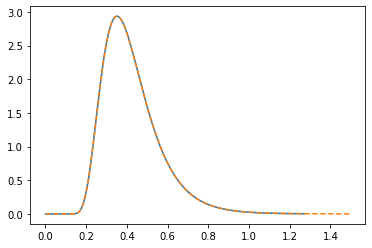

In [28]:
from rl import lognpdf

sigma = 0.4
t0 = 0.1
D = 1.0
mu = -1.0

t = np.arange(0, 1.5, 0.005)
ln = lognpdf(t, mu=mu, sigma=sigma, t0=t0, D=D)

alpha = 0.85
ln2 = lognpdf(t, mu=mu + np.log(alpha), sigma=sigma, t0=t0*alpha, D=D*alpha)

plt.plot(alpha*t, ln)
plt.plot(t, ln2, linestyle="dashed")

In [29]:
alphas = ((segment_df.rel_p3 - segment_df.rel_p1)/2/segment_df.sfreq)
segment_df["alpha"] = [np.mean(row) for row in alphas.values]

In [ ]:

alpha_df = []
for no, row in tqdm(list(segment_df.iterrows())):
    alphas = ((row.rel_p1 + row.rel_p3)/2/row.sfreq)
    no_beat = np.arange(row.clean_beats.shape[0])
    assert(len(no_beat == len(alphas)))

    res_dict = row[['subject', 'age', 'condition']].to_dict()
    res_dict['no_beat'] = no_beat
    res_dict['alpha'] = alphas
    res_dict["subject"] = int(res_dict["subject"])
    alpha_df.append(pd.DataFrame(res_dict))          

alpha_df = pd.concat(alpha_df)

In [ ]:
df_ind_peaks_corrected =  pd.concat([pd.read_csv(Path(f"ind_params_{row['subject']}_{row['age']}_{row['condition']}.csv")).loc[:, "subject":] 
                                     for _, row in tqdm(list(segment_df.iterrows()))]).reset_index() 

df_ind_peaks_corrected = df_ind_peaks_corrected.merge(alpha_df, on=["age", "subject", "condition", "no_beat"])

for comp in "PQRSTU":    
    alpha = df_ind_peaks_corrected[f"alpha"]
    df_ind_peaks_corrected[f"{comp}_mu"] += np.log(alpha)
    df_ind_peaks_corrected[f"{comp}_D"] *= alpha    
    df_ind_peaks_corrected[f"{comp}_t0"] *= alpha  

Percentage of discaded segments because of SNR < 5 dB: 18.2887785924339%
{0.25: 1, 1.0: 9, 2.0: 13, 3.0: 19, 4.0: 21, 6.0: 14, 9.0: 19, 12.0: 17, 15.0: 9, 18.0: 7, 24.0: 4}


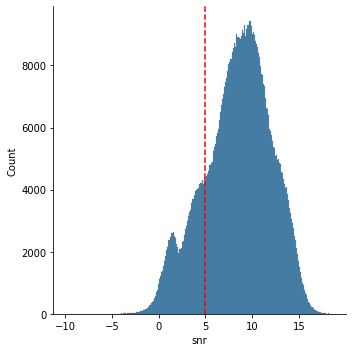

In [32]:
print(f"Percentage of discaded segments because of SNR < 5 dB: {np.sum(df_ind_peaks_corrected.snr < 5)/len(df_ind_peaks_corrected.snr)*100}%")
sns.displot(df_ind_peaks_corrected.snr)
plt.axvline(x=5, color="r", linestyle="dashed")

df_ind_peaks_corrected = df_ind_peaks_corrected[df_ind_peaks_corrected.snr >= 5]

df_means_corrected = df_ind_peaks_corrected.groupby(["age", "subject", "condition"]).mean().reset_index()
df_means_corrected = df_means_corrected.groupby(["age", "subject"]).mean().reset_index()

ages = np.array([age.split("m")[0] for age in df_means_corrected.age]).astype(object)
ages[ages == "1w"] = 0.25
df_means_corrected["age_num"] = ages.astype(float)

df_means_corrected = df_means_corrected.groupby(["age", "subject", "age_num"]).mean().reset_index()

# Keeping only the time points with at least 10 subjects
tmp = df_means_corrected.groupby(["age_num"]).count()
print(dict(tmp["age"]))


df_means_corrected = df_means_corrected[np.in1d(df_means_corrected.age_num, tmp.index[tmp["subject"] >= 8])]

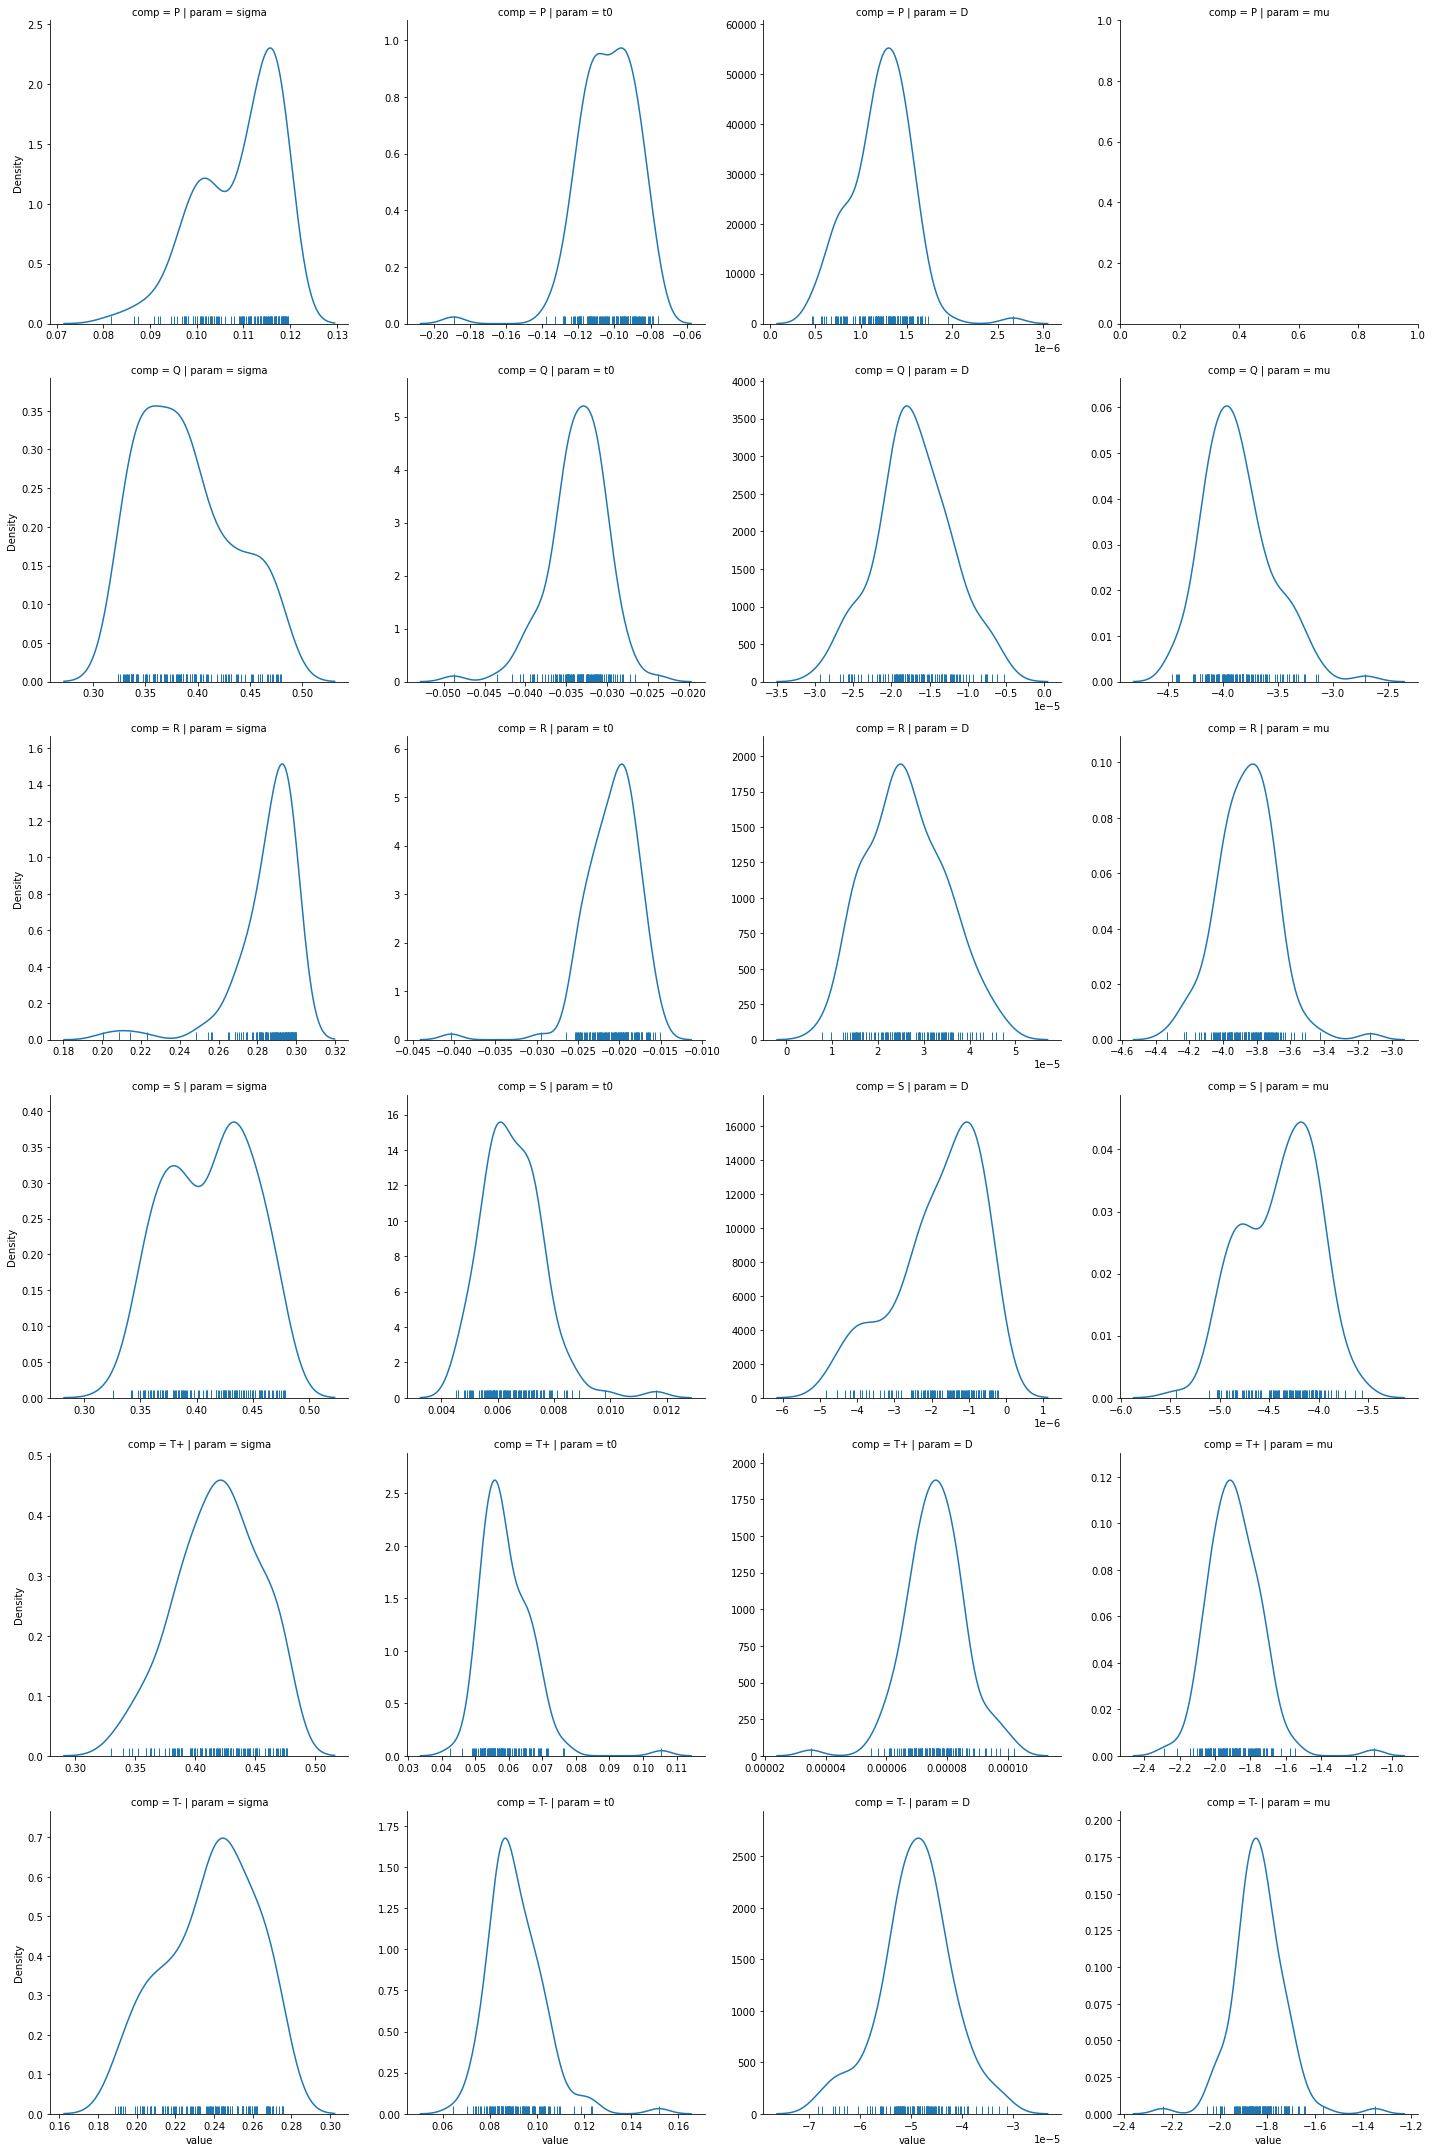

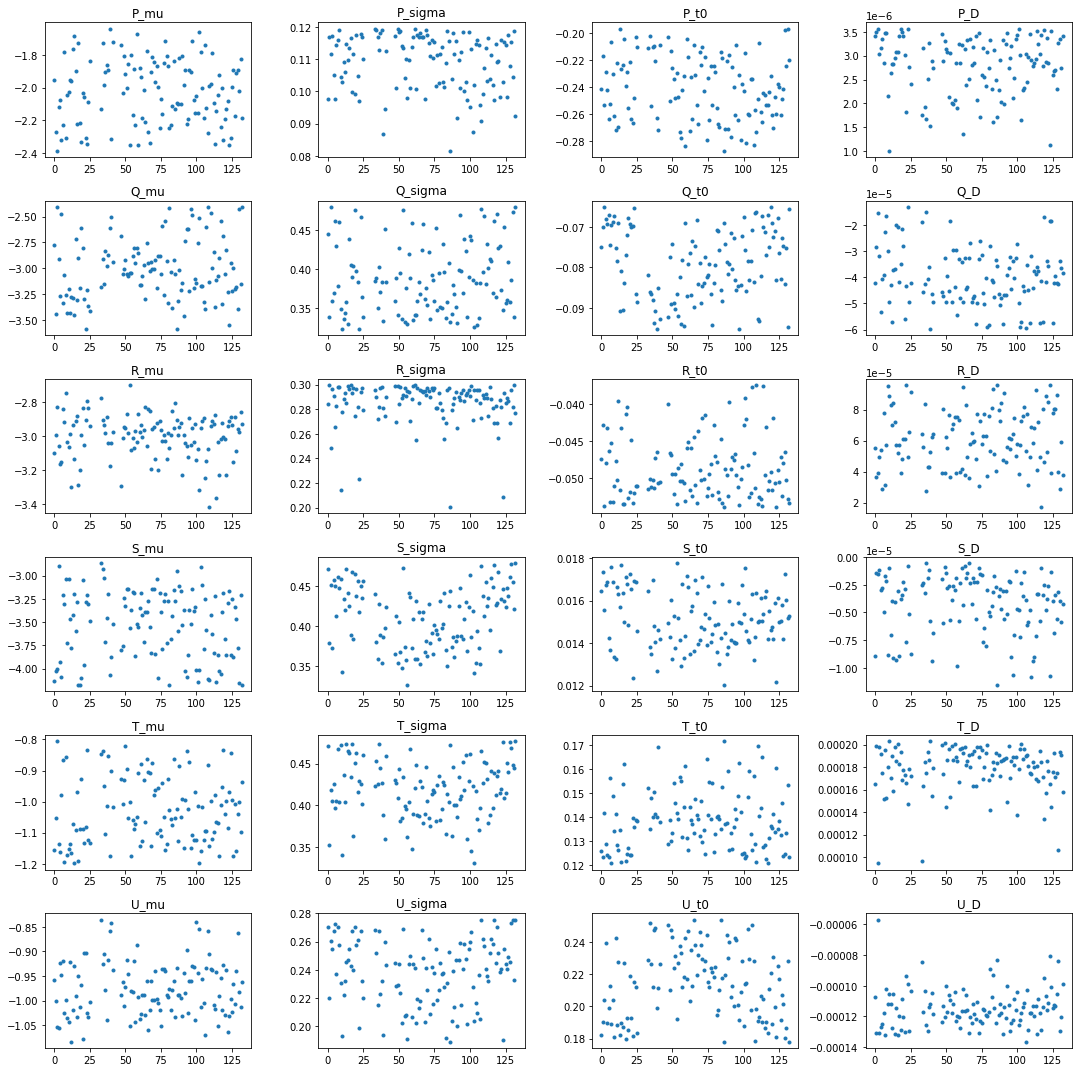

In [33]:
plot_dists(df_means_corrected.drop(columns="alpha"))

In [ ]:
pred_df_corrected = get_pred_df(df_means_corrected)

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(9, 9), sharex="col", sharey=True)

plot_mean_per_age(pred_df_corrected, xlims=(-0.1, 0.35), restore_scale=True, fig_axes=(fig, axes.T[0]))
plot_mean_per_age(pred_df_corrected, xlims=(-0.08, 0.05), restore_scale=True, fig_axes=(fig, axes.T[1]), show_legend=False)

for ax in axes.T[1]:
    ax.set_ylabel("")
for ax in axes[-1]:
    ax.set_xlabel("time (s)")


fig.tight_layout()
fig.savefig("predicted_pqrst_corrected.png", dpi=300)

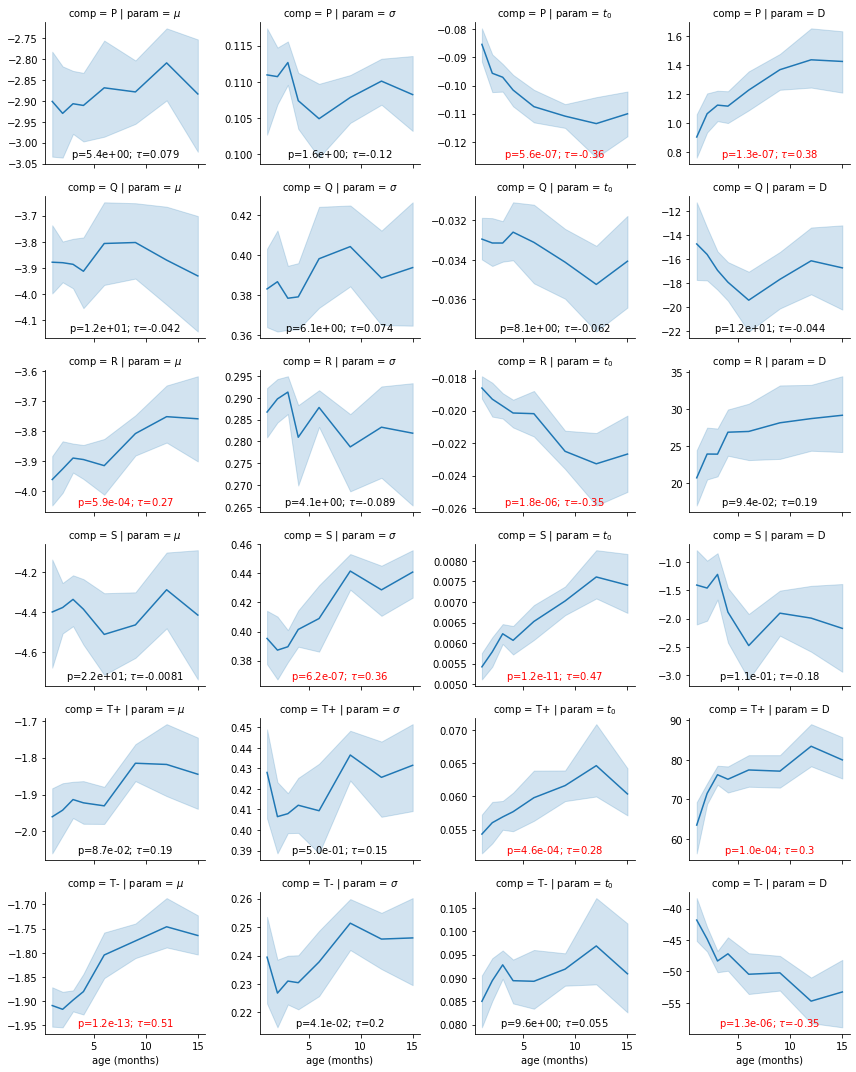

In [36]:
plot_param_age_trends(df_means_corrected.drop(columns="alpha"), "parameter_trends_corrected.png")


In [41]:
df_means_corrected.groupby("age_num").count().age

age_num
1.0      9
2.0     13
3.0     19
4.0     21
6.0     14
9.0     19
12.0    17
15.0     9
Name: age, dtype: int64